## BIOE 485 Final Project

First we read in the data

Need Python 3.10

In [26]:
import SimpleITK as sitk
import numpy as np
from scipy.ndimage import zoom


images = []
resample_factors = (64 / 256, 128 / 512, 128 / 512)


for num in [915, 925, 935, 945, 955, 995]:
    img = sitk.ReadImage(f'./Heart/Predicted_NIfTI_masks/heart_{num}.nii.gz')
    arr = sitk.GetArrayFromImage(img)
    downsampled_arr = zoom(arr, resample_factors, order=1)  # order=1 for linear interpolation
    images.append(downsampled_arr)
    # images.append(arr)
print("Finished Loading Images")

print("\nSanity size Check")
for i in images:
    print(i.shape)

Finished Loading Images

Sanity size Check
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)
(64, 128, 128)


Run Some Sanity Check to see the images

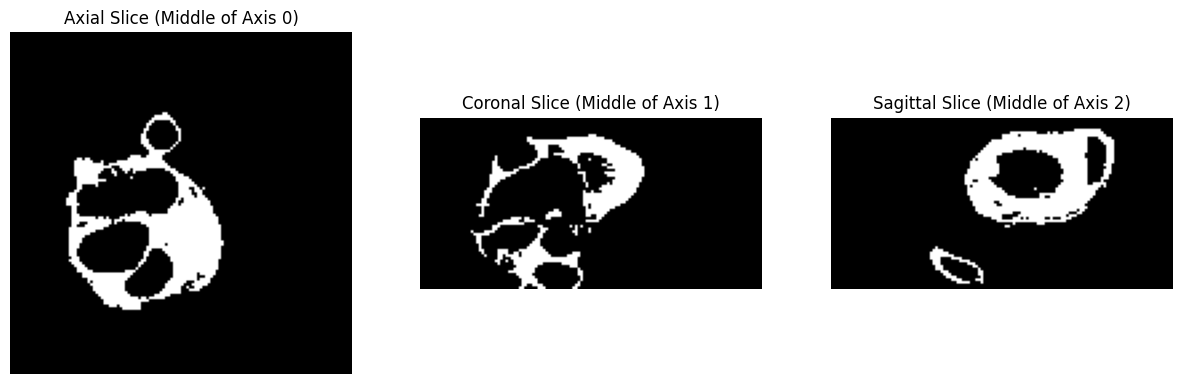

In [28]:
import matplotlib.pyplot as plt

# Assuming images[0] is a 3D Numpy array
data = images[0]

# Visualizing a slice from the middle along each axis
plt.figure(figsize=(15, 5))

# Slice along the axial plane (axis 0)
plt.subplot(1, 3, 1)
plt.title("Axial Slice (Middle of Axis 0)")
plt.imshow(data[data.shape[0] // 2, :, :], cmap="gray")
plt.axis('off')

# Slice along the coronal plane (axis 1)
plt.subplot(1, 3, 2)
plt.title("Coronal Slice (Middle of Axis 1)")
plt.imshow(data[:, data.shape[1] // 2, :], cmap="gray")
plt.axis('off')

# Slice along the sagittal plane (axis 2)
plt.subplot(1, 3, 3)
plt.title("Sagittal Slice (Middle of Axis 2)")
plt.imshow(data[:, :, data.shape[2] // 2], cmap="gray")
plt.axis('off')

plt.show()


### Convert a single image into FBX without using PCA

In [29]:
import fbx
from skimage import measure
import nibabel as nib
from scipy.ndimage import gaussian_filter

# Load the NIfTI file
voxel_data = images[0].astype(int)
# voxel_data = transformed_img_array

# Can choose to apply gaussian filter
# smoothed_data = gaussian_filter(voxel_data, sigma=1)  # Adjust sigma for smoothing intensity
# verts, faces, normals, _ = measure.marching_cubes(smoothed_data, level=0.3)
verts, faces, normals, _ = measure.marching_cubes(voxel_data, level=0.3)

# Initialize the FBX SDK
manager = fbx.FbxManager.Create()
scene = fbx.FbxScene.Create(manager, "MyScene")

# Create a mesh object
mesh = fbx.FbxMesh.Create(scene, "MyMesh")

# Set the vertices in the FBX mesh
mesh.InitControlPoints(len(verts))
for i, vert in enumerate(verts):
    mesh.SetControlPointAt(fbx.FbxVector4(*vert), i)

# Add polygons to the mesh
for face in faces:
    mesh.BeginPolygon()
    for idx in face:
        mesh.AddPolygon(idx)
    mesh.EndPolygon()

# Create a node for the mesh
mesh_node = fbx.FbxNode.Create(scene, "MyMeshNode")
mesh_node.SetNodeAttribute(mesh)

# Add the mesh node to the scene
scene.GetRootNode().AddChild(mesh_node)

# Export the scene to an FBX file
exporter = fbx.FbxExporter.Create(manager, "")
exporter.Initialize("Single fbx without PCA.fbx", -1, manager.GetIOSettings())
exporter.Export(scene)
exporter.Destroy()
manager.Destroy()
print("Single Warped FBX")


import os

# Specify the path to your FBX file
fbx_file_path = "Single fbx without PCA.fbx"

# Check if the file exists and get its size in MB
if os.path.exists(fbx_file_path):
    file_size_bytes = os.path.getsize(fbx_file_path)
    file_size_mb = file_size_bytes / (1024 * 1024)  # Convert bytes to MB
    print(f"File size: {file_size_mb:.2f} MB")
else:
    print("File not found")


Single Warped FBX
File size: 0.86 MB


### PCA Function

In [30]:
from scipy.sparse.linalg import eigsh

def pca(data, n_comps):
    x_hat = data - np.mean(data, axis=1, keepdims=True)
    cov = np.cov(x_hat, rowvar=True)
    eigenvalues, eigenvectors = eigsh(cov, k=n_comps)
    return eigenvalues, eigenvectors

### Do a PCA on the image data

In [31]:
print("Flatten the data")
imgs = images[0].reshape(images[0].shape[0], -1)
print(imgs.shape)

Flatten the data
(64, 16384)


In [32]:
%%time
# TODO - Perform PCA on the flattened images using the same pca() function written before
# NOTE - THIS WILL TAKE A LONG TIME! AT LEAST 7 MINUTES
vals, vectors = pca(imgs.T, 2000)
print("Done")

Done
CPU times: total: 1h 7min 23s
Wall time: 10min 34s


In [33]:
# save the eigenvalues and eigenvectors to a .npy file
import pickle

with open('vals.npy', 'wb') as f:
    pickle.dump(vals, f)

with open('vectors.npy', 'wb') as f:
    pickle.dump(vectors, f)  

# # Can reload them if needed.
# with open('vals.npy', 'rb') as f:
#     vals = pickle.load(f)

# with open('vectors.npy', 'rb') as f:
#     vectors = pickle.load(f)

vals = vals[::-1]
vectors = vectors[:, ::-1]


vals.shape, vectors.shape

((2000,), (16384, 2000))

Text(0, 0.5, 'Eiegenvalue')

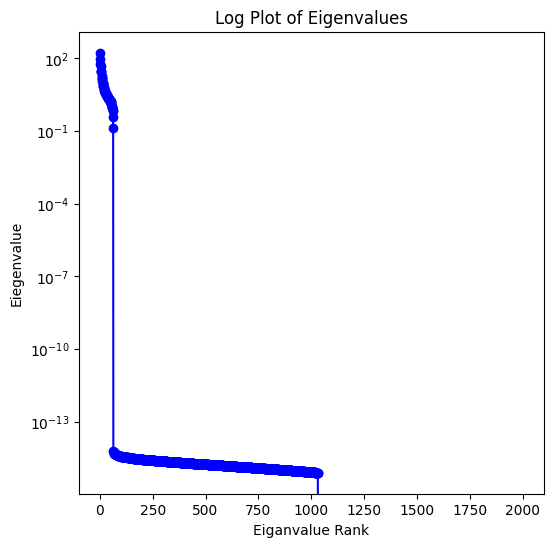

In [42]:
# Plot eigenvalues in decreasing order using plt.plot()

x = np.arange(vals.shape[0]-1,-1,-1)
plt.figure(figsize=(6,6))

# TODO:
plt.plot(np.arange(1, 2000 + 1), vals, marker='o', linestyle='-', color='b')

plt.yscale('log')
plt.title('Log Plot of Eigenvalues')
plt.xlabel('Eiganvalue Rank')
plt.ylabel('Eiegenvalue')

In [43]:
from sklearn.decomposition import PCA

image_flat = images[0].reshape(images[0].shape[0], -1)

num_comps = [10, 20, 50]

reconstructed_images = []

for n in num_comps:
    print(f"\nReconstructing with {n} components...")
    # Perform PCA on the flattened first image
    pca = PCA(n_components=n)
    transformed = pca.fit_transform(image_flat)  # Reduce dimensions
    reconstructed_flat = pca.inverse_transform(transformed)  # Reconstruct image

    # Reshape back to the original 3D shape
    reconstructed_img = reconstructed_flat.reshape(images[0].shape)
    reconstructed_images.append(reconstructed_img)

# Sanity check the shapes of reconstructed images
for idx, n in enumerate(num_comps):
    print(f"Reconstructed image with {n} components has shape: {reconstructed_images[idx].shape}")


Reconstructing with 10 components...

Reconstructing with 20 components...

Reconstructing with 50 components...
Reconstructed image with 10 components has shape: (64, 128, 128)
Reconstructed image with 20 components has shape: (64, 128, 128)
Reconstructed image with 50 components has shape: (64, 128, 128)
